In [1]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import TimeDistributed,Activation

from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

C:\Users\kmura\AppData\Local\Programs\Python\Python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
import numpy as np

# Pre-process the data

In [3]:
from pickle import dump
from pickle import load
import pickle
with open("data/telugu_pos_tag_data.pickle","rb") as fhnd:
    total_data=pickle.load(fhnd)

In [4]:
word_to_idx=load(open("data/word_to_idx.pickle","rb"))

pos_map=load(open("data/pos_map.pickle","rb"))

# Converge all sentences into one big list and their pos tags into another simultaneous list

# train_data = [1,3,4,2,789,........, 103589]

In [5]:
sentences=[]
labels=[]

train_data=[]
label_data=[]

target_task_indx_start=0
target_task_indx_end=0

length = 5


for m,(sent,tag) in enumerate(total_data):
    sentences+=sent
    labels+=tag
    for wrdi in sent:
        res=word_to_idx[wrdi]
        train_data.append(res)
    
    for tagi in tag:
        res=pos_map[tagi]
        label_data.append(res)
    


# For fit generator multiple outputs
https://github.com/keras-team/keras/blob/master/keras/engine/training.py#L1128

# Example
        
def generate_arrays_from_file(path):

    while True:
        with open(path) as f:
            for line in f:
                # create numpy arrays of input data
                # and labels, from each line in the file
                x1, x2, y = process_line(line)
                yield ({'input_1': x1, 'input_2': x2}, {'output': y})

model.fit_generator(generate_arrays_from_file('/my_file.txt'),steps_per_epoch=10000, epochs=10)
   

# Generator class

In [6]:
class KerasBatchGenerator(object):

    def __init__(self, data, labeldata,num_steps, batch_size, vocabulary, pos_tag_size,skip_step):
        self.data = data
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.vocabulary = vocabulary
        self.labeldata=labeldata
        self.pos_tag_size=pos_tag_size
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0
        # skip_step is the number of words which will be skipped before the next
        # batch is skimmed from the data set
        self.skip_step = skip_step

    def generate(self,phase=None):
        x = np.zeros((self.batch_size, self.num_steps))
        
        if phase==None:
            print("Phase not mentioned!!!!!")
            return 
        
        if phase==1:
            y = np.zeros((self.batch_size, self.vocabulary))
        
        if phase==2:
            y = np.zeros((self.batch_size, self.vocabulary))
            phase2_y = np.zeros((self.batch_size, self.num_steps, self.pos_tag_size))
        

        
        while True:
            for i in range(self.batch_size):
                if self.current_idx + self.num_steps >= len(self.data):
                    # reset the index back to the start of the data set
                    self.current_idx = 0
                
                x[i, :] = self.data[self.current_idx:self.current_idx + self.num_steps]

                
                if phase==1:
                    
#                     temp_y = self.data[self.current_idx + 1:self.current_idx + self.num_steps + 1]
                    temp_y = self.data[self.current_idx+self.num_steps]
                    # convert all of temp_y into a one hot representation
                    y[i, :] = to_categorical(temp_y, num_classes=self.vocabulary)
#                     self.current_idx += self.skip_step                    
                    yield x, y
                
                
                elif phase==2:

                    temp_y = self.data[self.current_idx +  self.num_steps ]
                    # convert all of temp_y into a one hot representation
                    y[i, :] = to_categorical(temp_y, num_classes=self.vocabulary)        
                    temp_phase2_y = self.labeldata[self.current_idx:self.current_idx + self.num_steps]
                    # convert all of temp_y into a one hot representation
                    phase2_y[i, :, :] = to_categorical(temp_phase2_y, num_classes=self.pos_tag_size)
                    yield ({'main_input': x}, {'LM_output': y,'POS_output':phase2_y})
                self.current_idx += self.skip_step                    


    
            


In [7]:
vocabulary=len(word_to_idx)
pos_tag_size=len(pos_map)

In [8]:
num_steps = 5
batch_size = 20
phase1_train_data_generator = KerasBatchGenerator(train_data,label_data, num_steps, batch_size, vocabulary,pos_tag_size,skip_step=1)
phase2_train_data_generator = KerasBatchGenerator(train_data,label_data, num_steps, batch_size, vocabulary,pos_tag_size,skip_step=1)

# ***** Actual required Design for the model *******

In [9]:
max_input_length=num_steps
embedding_dim=300
vocab_size=vocabulary
hidden_dim=200


main_input = Input(shape=(max_input_length,), dtype='float32', name='main_input')

# This embedding layer will encode the input sequence
# into a sequence of dense 512-dimensional vectors.

x = Embedding(output_dim=embedding_dim, input_dim=vocab_size, input_length=max_input_length,name="embedding")(main_input)

# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out,state_h, state_c = LSTM(hidden_dim,return_sequences=True, return_state=True,name="LSTM")(x)

print(lstm_out.shape)

auxiliary_output = TimeDistributed(Dense(pos_tag_size, activation='sigmoid'), name='POS_output')(lstm_out)

# auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(lstm_out)

# auxiliary_input = Input(shape=(5,), name='aux_input')
# x = keras.layers.concatenate([lstm_out, auxiliary_input])


# We stack a deep densely-connected network on top

# x = Dense(400, activation='relu',name="dense")(state_h)

# x = Dense(64, activation='relu')(x)
# x = Dense(64, activation='relu')(x)

# And finally we add the main logistic regression layer
main_output = Dense(vocab_size, activation='softmax', name='LM_output')(state_h)

phase1_model= Model(inputs=[main_input], outputs=[main_output])
phase2_model = Model(inputs=[main_input], outputs=[main_output, auxiliary_output])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
(?, ?, 200)


# Compiling the models

In [10]:
phase2_model.compile(loss={'LM_output': 'categorical_crossentropy', 'POS_output': 'mse'},optimizer='rmsprop',metrics=['accuracy'])
phase1_model.compile(loss={'LM_output': 'categorical_crossentropy'},optimizer='adam',metrics=['accuracy'])

# model.compile(optimizer='rmsprop',
#               loss={'main_output': 'binary_crossentropy', 'aux_output': 'binary_crossentropy'},
#               loss_weights={'main_output': 1., 'aux_output': 0.2})


Instructions for updating:
keep_dims is deprecated, use keepdims instead


# Save the models to image files and display them

In [11]:
plot_model(phase1_model,to_file='phase1_model_mine.png',show_shapes=True)
plot_model(phase2_model,to_file='phase2_model_mine.png',show_shapes=True)


# Phase 1 model architecture

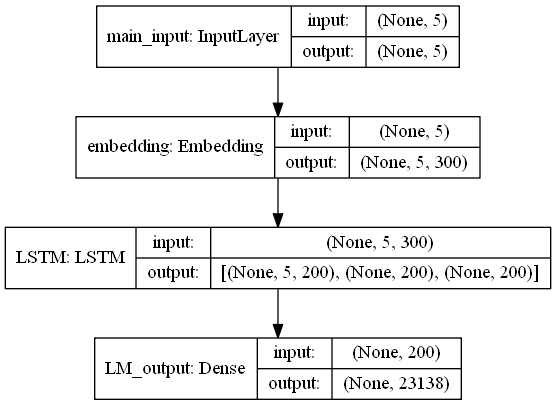

In [12]:
from IPython.display import Image
Image("phase1_model_mine.png")


# Phase 2 model architecture

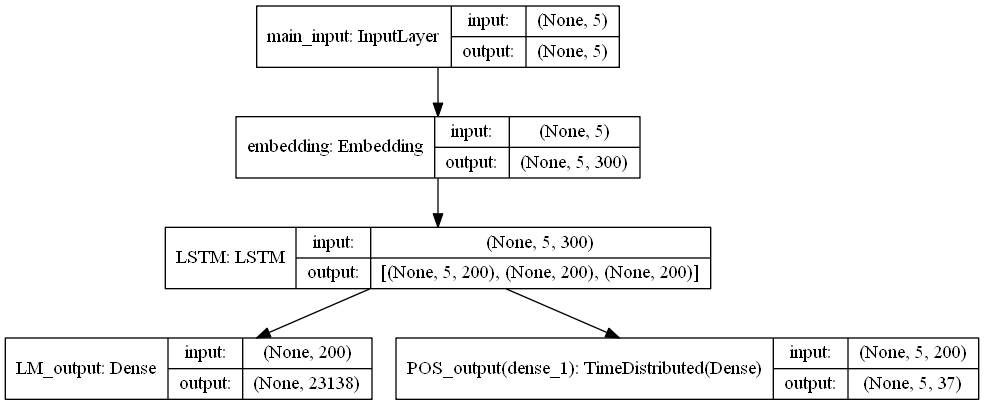

In [13]:
Image("phase2_model_mine.png")

# Creating random data. Phase 2 y label has (100, 30, 38) shape. Phase 1 y label has (100, 23138). X has (100,30). 30 is the time sequences. 23138 is vocab size.

# 38 is the number of pos tags 


In [124]:
# import numpy as np
# TRAIN_SIZE = 100
# # x=np.random.uniform(0, 10, (TRAIN_SIZE, 2))
# x=np.random.randint(10, size=(TRAIN_SIZE,30))
# print("x is ",x[0])
# print("x shape is ",x.shape)
# phase2_y=np.random.randint(10, size=(TRAIN_SIZE,30))
# phase1_Y=np.random.randint(10, size=TRAIN_SIZE)
# phase1_Y=to_categorical(phase1_Y,23138)
# print(phase2_y[0])

# sequences = [to_categorical(y, num_classes=38) for y in phase2_y]
# phase2_y = array(sequences)


# # print(phase1_Y[0])

# # print(len(x))
# # print(len(phase1_Y))
# print(phase2_y[0])
# print(phase2_y.shape)
# print(phase1_Y.shape)

# Fitting the data to phase1 model(Language model).

In [14]:
num_epochs=20

In [15]:
phase1_checkpointer = ModelCheckpoint('data/phase1_model-{epoch:20}.hdf5', verbose=1)

In [ ]:
# phase1_model.fit_generator(phase1_train_data_generator.generate(phase=1), len(train_data)//(batch_size*num_steps), num_epochs, callbacks=[checkpointer])

skip_steps=1
phase1_model.fit_generator(phase1_train_data_generator.generate(phase=1), len(train_data)//(batch_size*skip_steps), num_epochs)


# model.fit_generator(train_data_generator.generate(), 2000, num_epochs,
    #                     validation_data=valid_data_generator.generate(),
    #                     validation_steps=10)


Epoch 1/20
5179/5179 [==============================] - 202s - loss: 5.1258 - acc: 0.3321   
Epoch 2/20
5179/5179 [==============================] - 206s - loss: 3.7708 - acc: 0.5502   
Epoch 3/20
5179/5179 [==============================] - 206s - loss: 4.8412 - acc: 0.5163   
Epoch 4/20
5179/5179 [==============================] - 206s - loss: 6.0779 - acc: 0.5053   
Epoch 5/20
5179/5179 [==============================] - 205s - loss: 7.4971 - acc: 0.4390   
Epoch 6/20
 159/5179 [..............................] - ETA: 198s - loss: 6.9453 - acc: 0.4623

In [81]:
phase1_model.save("data/phase1_model.hdf5")

In [3]:
# phase1_model.fit(x,{'LM_output':phase1_Y},epochs=20)

# Store the weights of phase 1 model's layers

In [82]:
phase1_model_weights = [(layer.name,layer.get_weights()) for layer in phase1_model.layers]

In [ ]:
for w in phase1_model_weights:
    print(w)

# For every phase1 model layer that is present in phase2, we assign the stored 

# weights to the corresponding layers.

In [103]:
for i in range(len(phase1_model_weights)):
    if not phase2_model.get_layer(phase1_model_weights[i][0])==None:
        print(phase1_model_weights[i][0]," layer weights are assigned ")
        phase2_model.get_layer(phase1_model_weights[i][0]).set_weights(phase1_model_weights[i][1])
    else:
        print(phase1_model_weights[i][0]," layer with weights ",phase1_model_weights[i][1]," are not copied")

main_input  layer weights are assigned 
embedding  layer weights are assigned 
LSTM  layer weights are assigned 
dense  layer weights are assigned 
LM_output  layer weights are assigned 


# Run phase2_model . phase2_model.fit

In [ ]:
# phase2_model.fit_generator(phase2_train_data_generator.generate(phase=2), len(train_data)//(batch_size*num_steps), num_epochs, callbacks=[checkpointer])
phase2_model.fit_generator(phase2_train_data_generator.generate(phase=2), len(train_data)//(batch_size), num_epochs)

    # model.fit_generator(train_data_generator.generate(), 2000, num_epochs,
    #                     validation_data=valid_data_generator.generate(),
    #                     validation_steps=10)
phase2_model.save("phase2_model.hdf5")

In [4]:
# model.add(Activation('softmax'))

# phase2_model.fit(x,{'LM_output':phase1_Y,'POS_output':phase2_y},epochs=20)

# < E O Required Model>

# Reference stuff below

In [13]:
temp_weights = [(layer.name,layer.get_weights()) for layer in model.layers]

In [ ]:
for w in temp_weights:
    print(w)

In [ ]:
for i in range(len(temp_weights)):
    model.layers[i].set_weights(temp_weights[i])
    
# model.get_layer("aux_output")